# Segmentation into ERP Epochs

The ERP analysis process involves segmenting continuous EEG data into **epochs** time-locked to experimental events of interest.

Epochs are specific, fixed-length segments of a continuous EEG data that are extracted for analysis.

This is the stage at which we move from working with EEG data, to ERP data.

ERPs are short segments of EEG data that are time-locked to particular events such as stimulus onsets or participant responses.

By averaging many epochs of the same type, researchers can single out the tiny event-related brain signals from the much larger background EEG noise.

In the previous steps we removed artifacts from the continuous EEG data.

Now, we will carry out the following steps:
* Segment the data into epochs.
* Apply artifact correction to the segments, based on the ICA decomposition that we performed in a previous step.
* Use the AutoReject algorithm to automatically detect and remove bad epochs and channels that ICA may not fix.


## Install MNE Library

In [1]:
# install MNE library
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 62.8 MB/s eta 0:00:00


## Install autoreject Library

In [2]:
!pip install autoreject

## Download EEG Data Files

We download the filtred data file and the ICA datafile saved in previuos steps:

In [3]:
# download EEG data files
!wget https://datascience.faseela.ma/wp-content/uploads/data-science/N400_dataset_14-filt-raw.fif
!wget https://datascience.faseela.ma/wp-content/uploads/data-science/N400_dataset_14-ica.fif

--2026-01-07 14:37:30--  https://datascience.faseela.ma/wp-content/uploads/data-science/N400_dataset_14-filt-raw.fif
Resolving datascience.faseela.ma (datascience.faseela.ma)... 169.60.78.87
Connecting to datascience.faseela.ma (datascience.faseela.ma)|169.60.78.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39961406 (38M) [application/octet-stream]
Saving to: ‘N400_dataset_14-filt-raw.fif’

N400_dataset_14-fil 100%[===================>]  38.11M  56.8MB/s    in 0.7s    

2026-01-07 14:37:31 (56.8 MB/s) - ‘N400_dataset_14-filt-raw.fif’ saved [39961406/39961406]

--2026-01-07 14:37:31--  https://datascience.faseela.ma/wp-content/uploads/data-science/N400_dataset_14-ica.fif
Resolving datascience.faseela.ma (datascience.faseela.ma)... 169.60.78.87
Connecting to datascience.faseela.ma (datascience.faseela.ma)|169.60.78.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6570 (6.4K) [application/octet-stream]
Saving to: ‘N400_dataset_14-

## Import Libraries

In [4]:
import mne
mne.set_log_level('error')

import matplotlib.pyplot as plt
import numpy as np

## Read the Filtered Data

We will segment the band-pass filtered version of the continuous EEG data that we created in the filtering step:

In [5]:
# read EEG filtered data
raw_filt = mne.io.read_raw_fif('N400_dataset_14-filt-raw.fif', preload='True')

# set the easycap-M1 montage to data
raw_filt.set_montage('easycap-M1', on_missing='ignore')


<Raw | N400_dataset_14-filt-raw.fif, 16 x 623850 (1247.7 s), ~76.2 MiB, data loaded>

## MNE’s Events Structure

**Event codes** indicate when events of experimental interest occurred during the EEG recording.

They are typically generated by the stimulus computer, and sent to the EEG recording computer at the same time that the stimuli are presented to the participant.

Event codes may also mark when a participant made a response (such as a button press, or the onset of a vocal response), or other information such as the start of a new bock of trials or condition, rather than a specific stimulus.

Segmenting the data into ERPs depends on these event codes, since they are what we time-lock to.

To use them for ERP segmentation, we need to first extract the timing and identity of each code from the raw data, and store it in a NumPy array.

Because event codes are numeric, we also need to define a mapping between these numbers and meaningful labels (such as what type of stimulus or experimental condition the code denotes).

We use the **`mne.events_from_annotations()`** function to extract the event codes from the raw data and store them in a NumPy array, which we assign it the variable name **`events`**.

The function actually produces two outputs; the second is a dictionary mapping the event codes to labels, which we assign it the variable name **`events_dict`**:

In [6]:
# extract event codes
events, events_dict = mne.events_from_annotations(raw_filt)

# view the first 10 rows of the events array
events[:10]

array([[    0,     0,     2],
       [   20,     0,     1],
       [59520,     0,     7],
       [59523,     0,     3],
       [60055,     0,    13],
       [60199,     0,     4],
       [61253,     0,     5],
       [63156,     0,     3],
       [63653,     0,    13],
       [63756,     0,     4]])

**`events`** is a NumPy array with 3 columns, and one row for each event code in the data.

The **first column** contains the index of the event code in terms of the data array.<br>
Recall that the data were sampled at a rate of 500 Hz, meaning we have one sample (i.e., measurement) every 2 ms. So the values in the first column of events are not time measured in milliseconds, but "time" in terms of samples or data points.<br>
This is important to remember later, although MNE generally makes it easy to go between samples and more intuitive measures of time like milliseconds or seconds.

The **second column** is usually zero, but is intended to mark the end time off an event, if the event code was send to the EEG system for a period of time. In practice it is rarely used, and we will ignore it.

The **third column** is the event code itself, as an integer.

## The Event Dictionary

MNE reads the event codes from a raw data file.

It searches through the raw data, and finds each unique event code.

It treats the event codes as strings, even if they are all numeric.

It then assigns each unique event code an integer value.

This mapping between original event codes and integers is stored in a dictionary to which we assigned the varaiable name **`events_dict`**:

In [7]:
# view mapping dictionary
events_dict

{np.str_('Comment/actiCAP Data On'): 1,
 np.str_('New Segment/'): 2,
 np.str_('Stimulus/S  1'): 3,
 np.str_('Stimulus/S  2'): 4,
 np.str_('Stimulus/S  3'): 5,
 np.str_('Stimulus/S  4'): 6,
 np.str_('Stimulus/S  5'): 7,
 np.str_('Stimulus/S  7'): 8,
 np.str_('Stimulus/S101'): 9,
 np.str_('Stimulus/S102'): 10,
 np.str_('Stimulus/S111'): 11,
 np.str_('Stimulus/S112'): 12,
 np.str_('Stimulus/S201'): 13,
 np.str_('Stimulus/S202'): 14,
 np.str_('Stimulus/S211'): 15,
 np.str_('Stimulus/S212'): 16}

The **`events_dict`** dictionary is critical to ensuring that you map the right event codes to the each event of experimental interest.

Another step is required, though, because we need a way of mapping from the codes that MNE is using in the data, to the labels for the events that make sense to us in terms of the experiment (e.g., different stimulus types, response onsets, etc.).

## Label Event Codes – Mapping Between Dictionaries

This data set was collected while the participant viewed a series of pictures of objects on a computer screen.

One second after each picture was presented, a spoken word was played over a speaker. The word was either the name of the pictured object, or some other word.

Based on prior research, it is predicted an N400 ERP component for the mismatch trials relative to those on which the picture and word matched.

In other words, the experimental contrast we are interested in is between **Match** and **Mismatch** trials.

We can define a dictionary that maps labels onto each original event code of interest:

In [8]:
# label event codes
event_mapping = {'PicOnset':'Stimulus/S  1',
                 'RespPrompt':'Stimulus/S  2',
                 'CorResp':'Stimulus/S  3',
                 'IncorResp':'Stimulus/S  4',
                 'RespFeedback':'Stimulus/S  5',
                 'unused':'Stimulus/S  7',
                 'Match/A':'Stimulus/S111',
                 'Match/B':'Stimulus/S211',
                 'Match/C':'Stimulus/S112',
                 'Match/D':'Stimulus/S212',
                 'Mismatch/A':'Stimulus/S101',
                 'Mismatch/B':'Stimulus/S201',
                 'Mismatch/C':'Stimulus/S102',
                 'Mismatch/D':'Stimulus/S202'
                }

We now need to map experiment labels to MNE's event codes.

We create a dictionary to map between the two dictionaries **`events_dict`** and **`event_mapping`**.

In [9]:
# make a dictionary to map experiment labels to MNE's event codes
event_id = {}

# map between dictionaries events_dict and event_mapping
for key, value in event_mapping.items():
    event_id[key] = events_dict[value]

event_id

{'PicOnset': 3,
 'RespPrompt': 4,
 'CorResp': 5,
 'IncorResp': 6,
 'RespFeedback': 7,
 'unused': 8,
 'Match/A': 11,
 'Match/B': 15,
 'Match/C': 12,
 'Match/D': 16,
 'Mismatch/A': 9,
 'Mismatch/B': 13,
 'Mismatch/C': 10,
 'Mismatch/D': 14}

## Plot Events Over Time

MNE **`mne.viz.plot_events()`** function reads an events array and plot the timing of event codes over the time, with different rows and colors for each event type.

We have to pass the sampling rate (**`raw.info['sfreq']`**) as the second argument so that MNE knows how to convert the samples in the **`events`** array to units of time.

We also pass the mapping between labels and event codes (**`event_id`**) so that the plot has a meaningful legend.

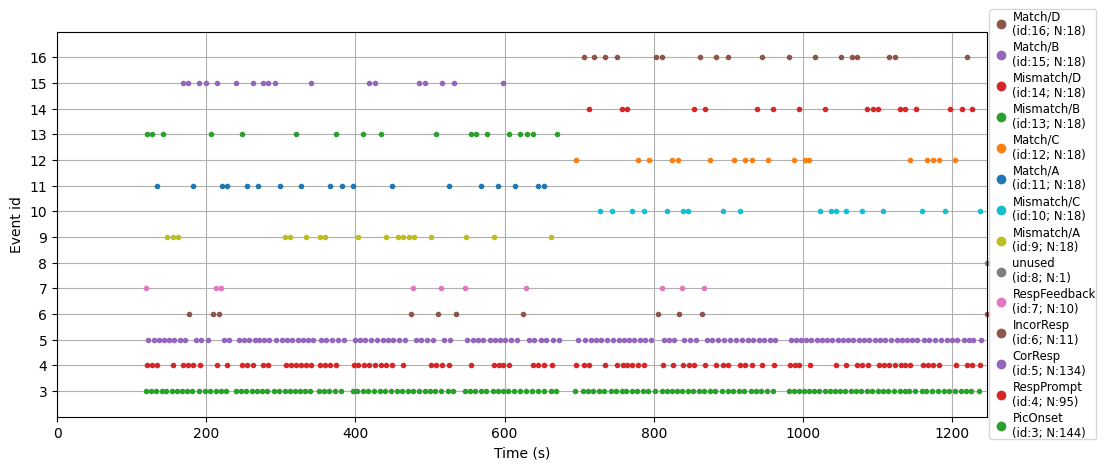

In [10]:
# plot events
fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(events, raw_filt.info['sfreq'],
                    event_id=event_id,
                    axes=ax);

This plot of event codes over time can be very useful in ensuring that the event codes in your experiment occurred as expected.

## Segment the Data into Epochs

Having extracted our event codes, and mapped them to labels, we are now ready to split the continuous filtered raw EEG data into **epochs** time-locked to the event codes of interest, as defined in the **`event_mapping`** dictionary we created above.

To do this we use the **`mne.Epochs()`** class constructor, which creates an object of the class **`Epochs`**.

**Parameters:**
* **`raw`**: the filtered raw data.
* **`events`**: the events array.
* **`event_id`**: the mapping of events to labels, we will use **`event_id`** dictioanry.
* **`tmin`**: the start time of each epoch.
* **`tmax`**: the end time of each epoch.
* **`baseline`**: a keyword argument, specifies what time period to use as the baseline for each epoch.

We use the setting `(None, 0)` for the baseline to specify the time period from the start of the epoch to the time of the event code.

Typically the minimum (start) time is a negative number, because we want a baseline period to compare to the activity after the event code (typically 50-200 ms).

In [11]:
# Epoching settings
tmin =  -.100  # start of each epoch (in sec)
tmax =  1.000  # end of each epoch (in sec)
baseline = (None, 0)

# Create epochs
epochs = mne.Epochs(raw_filt,
                    events, event_id,
                    tmin, tmax,
                    baseline=baseline,
                    preload=True
                   )

## **`Epochs`** Data Structure

The **`Epochs`** data structure is a key component for analyzing time-locked neural data (such as EEG/MEG).

It represents continuous data segmented into discrete trials and is stored internally as a NumPy array with the shape<br>
(**`n_epochs`**, **`n_channels`**, **`n_times`**).

#### Core Data Structure and Attributes

* **Data Array:** The primary data is a NumPy array accessible via the **`epochs.get_data()`** method (or **`epochs.events`** attribute for event information).
    * **`n_epochs`**: The total number of individual trials or events.
    * **`n_channels`**: The number of sensor channels.
    * **`n_times`**: The number of time samples within each epoch.

* **`info` Attribute:** This is a dictionary-like object that holds all recording details, preserved across **`Raw`**, **`Epochs`**, and **`Evoked`** objects. It contains information such as sampling frequency (**`sfreq`**), channel names (**`ch_names`**), and channel types.

* **`events` and `event_id` Attributes:**
    * **`events`**: A NumPy array of shape (**`n_events`**, 3), where the first column is the sample number of the event onset, and the third column is the integer event ID.
    * **`event_id`**: A dictionary that maps descriptive string labels (e.g., 'Auditory/Left') to their corresponding integer event IDs.

* **`times` Attribute:** A NumPy array of the time points in seconds relative to the event onset (time 0).

#### View **`Epochs`** Data

In [21]:
# shape of data array
print(epochs.get_data().shape, '\n')

# info attribute
print(epochs.info, '\n')

# events
print(epochs.events, '\n')

# events labels
print(epochs.event_id)

(539, 16, 551) 

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, C3, P3, TP9, Fz, Cz, Fp2, F4, F8, C4, P4, TP10, Pz, Oz
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 30.0 Hz
 meas_date: 2000-01-31 10:37:08 UTC
 meas_id: 4 items (dict)
 nchan: 16
 projs: []
 sfreq: 500.0 Hz
> 

[[ 59520      0      7]
 [ 59523      0      3]
 [ 60055      0     13]
 ...
 [619324      0      5]
 [623249      0      8]
 [623253      0      6]] 

{'PicOnset': 3, 'RespPrompt': 4, 'CorResp': 5, 'IncorResp': 6, 'RespFeedback': 7, 'unused': 8, 'Match/A': 11, 'Match/B': 15, 'Match/C': 12, 'Match/D': 16, 'Mismatch/A': 9, 'Mismatch/B': 13, 'Mismatch/C': 10, 'Mismatch/D': 14}


## Viewing and Indexing Epochs

Viewing **`Epochs`** prints an output with a summary of the contents of the data structure.

In [ ]:
# view Epochs contents
epochs

<Epochs | 539 events (all good), -0.1 – 1 s (baseline -0.1 – 0 s), ~36.3 MiB, data loaded,
 'PicOnset': 144
 'RespPrompt': 95
 'CorResp': 134
 'IncorResp': 11
 'RespFeedback': 10
 'unused': 1
 'Match/A': 18
 'Match/B': 18
 'Match/C': 18
 'Match/D': 18
 and 4 more events ...>

**`Epochs`** can be accessed in a variety of ways, all using square brackets `epochs[]`.

If we use an integer, we get the epoch at that index position (epochs are numbered from zero to the total number of epochs, in the order that the event codes occurred in the raw data):



In [ ]:
# access an epoch
epochs[0]

<Epochs | 1 events (all good), -0.1 – 1 s (baseline -0.1 – 0 s), ~94 KiB, data loaded,
 'RespFeedback': 1>

Accessing a slice of epochs:

In [ ]:
# access a slice of epochs
epochs[10:15]

<Epochs | 5 events (all good), -0.1 – 1 s (baseline -0.1 – 0 s), ~370 KiB, data loaded,
 'PicOnset': 1
 'RespPrompt': 1
 'CorResp': 1
 'Match/A': 1
 'Mismatch/B': 1>

We can access all of the epochs associated with a particular event code, using the label we assigned to the code using **`event_mapping`**:

In [ ]:
# access epochs associated with label Match/A
epochs['Match/A']

<Epochs | 18 events (all good), -0.1 – 1 s (baseline -0.1 – 0 s), ~1.2 MiB, data loaded,
 'Match/A': 18>

These two methods can be combined to select a specific event out of those in a condition:

In [ ]:
# access epoch with given index and event
epochs['Match/A'][8]

<Epochs | 1 events (all good), -0.1 – 1 s (baseline -0.1 – 0 s), ~94 KiB, data loaded,
 'Match/A': 1>

If we pass multiple condition labels, then we will get all epochs in each of the conditions specified:

In [ ]:
# access epochs with multiple conditions
epochs['Match/A', 'Match/B']

<Epochs | 36 events (all good), -0.1 – 1 s (baseline -0.1 – 0 s), ~2.4 MiB, data loaded,
 'Match/A': 18
 'Match/B': 18>

MNE also recognizes the / separator for condition labels (e.g., in **`'Match/A'`**).<br>
So we can see all of the Match trials (A, B, C, & D) by passing **`'Match'`** as the condition label:

In [ ]:
# access epochs  for condition labels Match
epochs['Match']

<Epochs | 72 events (all good), -0.1 – 1 s (baseline -0.1 – 0 s), ~4.9 MiB, data loaded,
 'Match/A': 18
 'Match/B': 18
 'Match/C': 18
 'Match/D': 18>

Likewise, we can see all of the epochs in the A condition (Match & Mismatch) by passing **`'A'`** as the condition label:

In [ ]:
# access epochs in the A condition
epochs['A']

<Epochs | 36 events (all good), -0.1 – 1 s (baseline -0.1 – 0 s), ~2.4 MiB, data loaded,
 'Match/A': 18
 'Mismatch/A': 18>

## Visualize Average ERP Across Conditions of Interest – Before Artifact Correction

The **`Epochs`** class has a **`plot()`** method to do visualize the data.

The **`Epochs`** object contains each individual trial.

Typically what we want to see is the average across all trials of a condition

This is central to ERPs, as the data on each individual trial is noisy, but when we average across many trials, the noise tends to cancel out, leaving the ERP component of interest.

To achieve this, MNE provides the **`Evoked`** data structure.

### **`Evoked`** Data Structure

**`Epochs`** data structure contains multiple trials, and each trial has an associated condition label (event code).

**`Evoked`** data structure represents averages across multiple trials for a single condition.

The averaging process increases the signal-to-noise ratio and reveals the ERPs time-locked to a specific event type.

We use the **`mne.Epochs.average()`** method to compute the average of all epochs in the **`Epochs`** object across trials.

The **`mne.Epochs.average()`** method returns an **`Evoked`** data structure.

The **`Evoked`** object is a core data structure in MNE.

It is used primarily for storing averaged data over trials in neurophysiological studies (EEG/MEG data)

This averaged data represents the typical brain response to a specific experimental condition or event (ERP).

We create an **`Evoked`** object for the Match condition, and an **`Evoked`** object for the Mismatch condition.

In [ ]:
# create an Evoked object for Match condition from an Epochs object
evoked_match = epochs['Match'].average()

# create an Evoked object for Mismatch condition from an Epochs object
evoked_mismatch = epochs['Mismatch'].average()

### Butterfly plot

We use the **`Evoked.plot()`** method to visualize averaged EEG data stored in an **`Evoked`** object as a butterfly plot.

Each line in the plot represents the signal from a single channel over time.

The color of the lines indicates where ont he head the channel was located, as shown in the inset head plot.

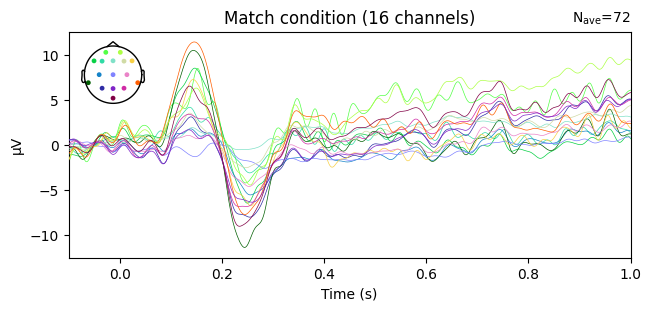

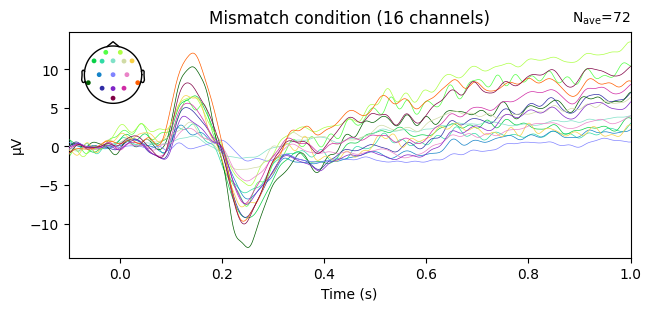

In [ ]:
# plot average ERP across Match epochs
evoked_match.plot(titles='Match condition');

# plot average ERP across Mismatch epochs
evoked_mismatch.plot(titles='Mismatch condition');

## Apply ICA Correction to Epochs

Recall that in the previous lesson, we saved the ICA decomposition to a file we named as `N400_dataset_14-ica.fif`.

We wil load that file and apply the ICA decomposition (and the exclusion of ICs) to the epochs data that we just created in the present lesson.

The **`ICA.apply()`** method operates on data in-place, meaning it alters the data that is passed to it.

In general, it’s good practice to make copies of data when applying transformations.

So here we use the **`copy()`** method:

In [ ]:
# read the ICA decomposition file
ica = mne.preprocessing.read_ica('N400_dataset_14-ica.fif')

# apply the ICA decomposition (excluding the marked ICs) to the epochs
epochs_postica = ica.apply(epochs.copy())

### Visualize Average ERP After ICA Artifact Correction

We create a figure with two subplots to visualize the butterfly plots before and after ICA correction.

In general, the artifact-corrected data shows less variance across channels.

This is an effect of removing ocular artifacts — blinks and eye movememnts are very large at the frontal channels and comparatively small at posterior channels — meaning the variance, or overall difference between channels, is large.

Removing those artifacts reduces the variance across channels.

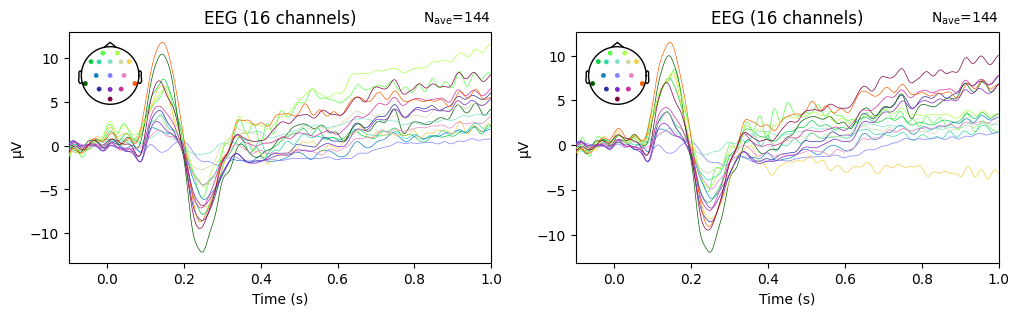

In [ ]:
# visualize average ERP after ICA artifact correction
fig, ax = plt.subplots(1, 2, figsize=[12, 3])

epochs['Match', 'Mismatch'].average().plot(axes=ax[0], show=False);
epochs_postica['Match', 'Mismatch'].average().plot(axes=ax[1]);

## AutoReject for Final Data Cleaning

ICA correction removed the ocular (blink and eye movement) artifacts.

However, there are potentially other sources of noise remaining in the data, including muscle noise, "paroxysmal" artifacts (sudden, large-amplitude deflections), and other sources.

Sometimes as well, individual channels contain noise either over the entire recording, or in specific segments.

We can use the AutoReject algorithm to automatically detect and remove bad epochs and channels.

Any channels that are removed are then replaced using interpolation by essentially averaging the data from surrounding channels to estimate the data from the noisy channel.

We apply the **`fit_transform()`** method, which both fits the model, and applies the "transformation" (i.e., the exclusion of bad epochs and interpolation of bad channels) to the data.

We include a keyword argument asking the method to output a log of the steps that AutoReject took to clean the data.

We can use this log to see what AutoReject did.

We assign the output of this method to two variables, **`epochs_clean`** and **`reject_log_clean`**. The first is the cleaned data, and the second is the log.

**Note:** AutoReject is a computationally-intensive algorithm, meaning it can take a long time to run, possibly several minutes.

In [ ]:
from autoreject import AutoReject

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_postica.info,
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1,
                verbose=False
                )

epochs_clean, reject_log_clean = ar.fit_transform(epochs_postica, return_log=True)

epochs_clean

<Epochs | 527 events (all good), -0.1 – 1 s (baseline -0.1 – 0 s), ~35.5 MiB, data loaded,
 'PicOnset': 143
 'RespPrompt': 94
 'CorResp': 125
 'IncorResp': 11
 'RespFeedback': 9
 'unused': 1
 'Match/A': 18
 'Match/B': 18
 'Match/C': 18
 'Match/D': 18
 and 4 more events ...>

### View AutoReject’s Effects

We plot the rejection log to see which epochs were rejected, and which channels were interpolated:

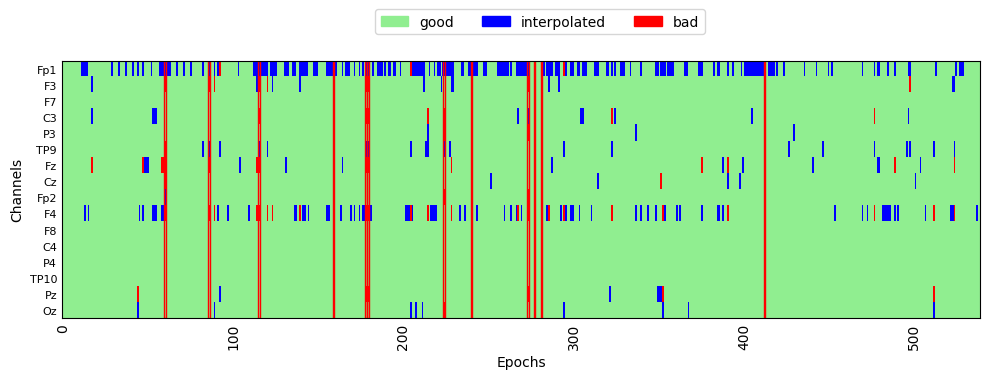

In [ ]:
fig, ax = plt.subplots(figsize=[10, 4])
reject_log_clean.plot('horizontal', aspect='auto', ax=ax);

### Visualize Average ERP After AutoReject

We plot the average ERPs across all Match and Mismatch trials, after AutoReject has been applied.

We create a figure with two subplots so we can compare the average before and after data cleaning with ICA + AutoReject:*italicized text*

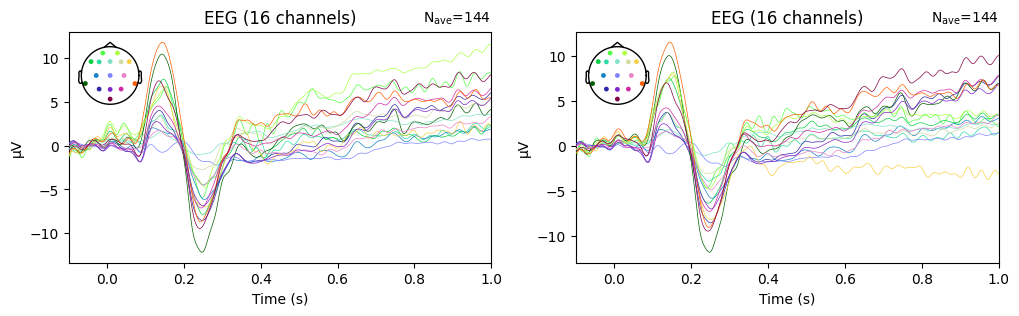

In [ ]:
# visualize average ERP after autoReject
fig, ax = plt.subplots(1, 2, figsize=[12, 3])

epochs['Match', 'Mismatch'].average().plot(axes=ax[0], show=False);
epochs_clean['Match', 'Mismatch'].average().plot(axes=ax[1]);

The data look very similar in the two panels, but there are some differences. In particular, the variability in amplitude across channels is larger prior to artifact removal.

Notably, the anterior channels (shown in green/yellow hues) seem to cluster together, and are different in amplitude from other channels.

This suggests that there were some ocular artifacts in the later portion of some of the epochs — since ocular artifacts are much larger over anterior than posterior channels.

After cleaning, the differences between channels are decreased, providing evidence that the cleaning process had an effect.

### Scalp Topography Maps

We plot the EEG potentials over the scalp, using the **`plot_topomap()`** method.

The code below generates a scalp map every 100 ms, which reflects the electrical potentials averaged over a 50 ms window centered on each time point

The time range over which each plot is averaged are shown in the labels above each scalp plot; the numbers are not precisely 50 ms ranges, because the sampling rate was 500 Hz, meaning that samples were acquired every 2 ms.

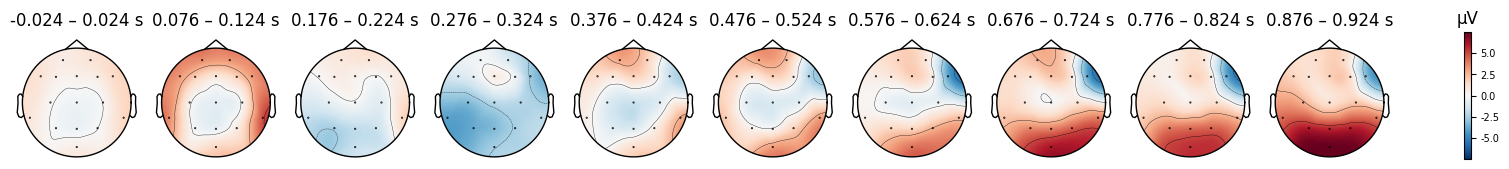

In [ ]:
# specify times to plot at, arguments: min, max, stepsize
times = np.arange(0, tmax, 0.1)

# plot scalp topography map for Match trials
epochs_clean['Match'].average().plot_topomap(times=times, average=0.050);

We plot the Mismatch trials separately from the Match trials, to see if there are any differences in the scalp topography of the ERPs between the two conditions:

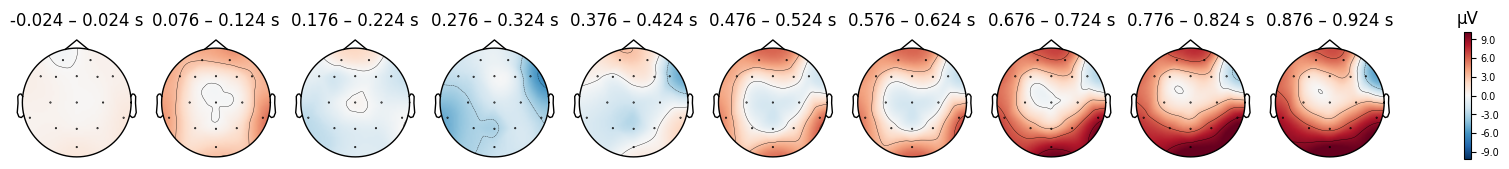

In [ ]:
# plot scalp topography map for Mismatch trials
epochs_clean['Mismatch'].average().plot_topomap(times=times, average=0.050);

There do seem to be differences, but be careful: look at the range of microVolt values in the colorbars for each plot. They are different.

To compare between two plots, we need to ensure that the colorbar ranges are the same for both.

We use the **`vlim`** keyword argument to specify the range of values to use for the y-axis and colorbar.

Here we use the same range for both conditions, so that we can compare them

Since one plot’s range is ±10 µV, and the other is ±6 µV, we use ±8 µV as a compromise.

Match


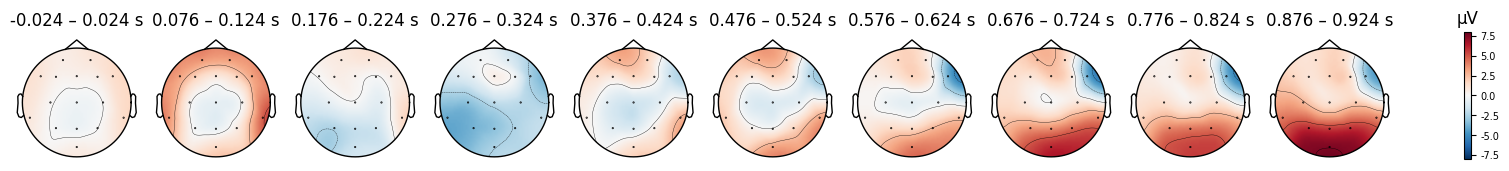

Mismatch


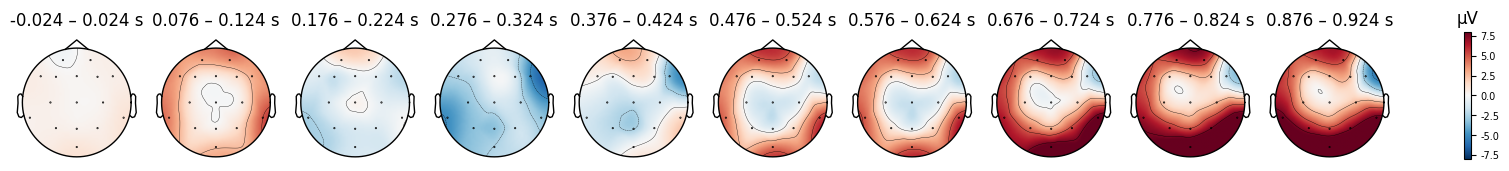

In [ ]:
# specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

print('Match')

# plot scalp topography map for Match trials
epochs_clean['Match'].average().plot_topomap(times=times, average=0.050, vlim=(-8, 8));

print('Mismatch')

# plot scalp topography map for Mismatch trials
epochs_clean['Mismatch'].average().plot_topomap(times=times, average=0.050, vlim=(-8, 8));

The differences between conditions appear smaller now, however some differences are still visible.

## Save epochs

We save the cleaned epochs to a file for use in later lessons. MNE requires the -epo suffix for .fif files storing epochs.

In [ ]:
# save epochs to file
epochs_clean.save('N400_dataset_14-epo.fif', overwrite=True)

[PosixPath('/content/N400_dataset_14-epo.fif')]